# Programmable Photonic Circuit

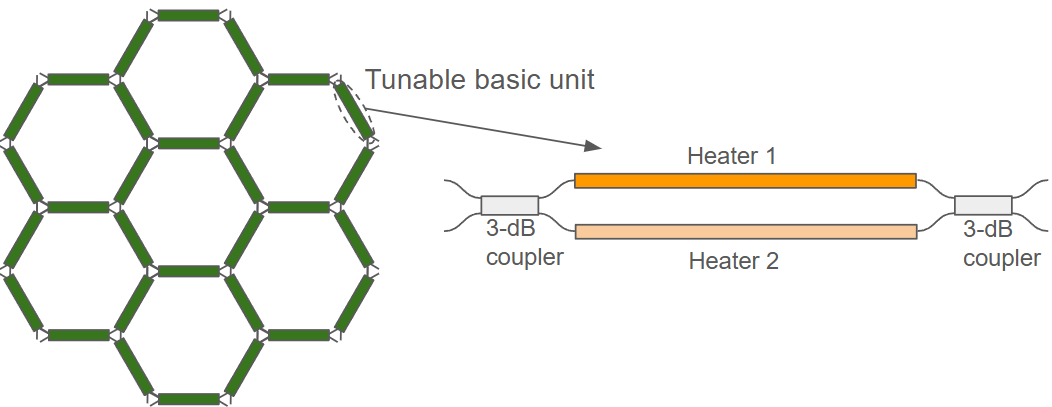



In this notebook, we create a programmable photonic circuit inspired by the works presented in [1] and [2]. This programmable circuit is based on a hexagonal lattice structure, where each link consists of a tunable Mach-Zehnder interferometer (MZI) with thermally controlled phase shifters on its arms. These thermal phase shifters allow us to individually adjust the optical path lengths, providing precise control over the interference within each MZI. By selectively tuning different units within the hexagonal lattice, we achieve a highly reconfigurable photonic platform capable of realizing various functional devices, such as unbalanced interferometers, finite impulse response (FIR) filters, add-drop filters, and more, as discussed in [1] and [2].

**References**
1. Pérez, Daniel, *et al*. "Multipurpose silicon photonics signal processor core." *Nature communications* 2017 8 (1), 636, doi: [10.1038/s41467-017-01529-w](https://doi.org/10.1038/s41467-017-01529-w).
2. Pérez-López, Daniel, *et al*. "Multipurpose self-configuration of programmable photonic circuits." *Nature communications* 2020 11 (1), 6359. doi: [10.1038/s41467-020-19608-w](https://doi.org/10.1038/s41467-020-19608-w).
3. Guan, Hang, *et al*. "Compact and low loss 90° optical hybrid on a silicon-on-insulator platform." *Optics Express* 2017 25 (23):,28957-28968. doi: [10.1364/OE.25.028957](https://doi.org/10.1364/OE.25.028957)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import siepic_forge as siepic_pdk
import tidy3d as td
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer(port=5002)

Starting live viewer at http://localhost:5002


We start by defining several default parameters for the notebook, including loading the [SiEPIC OpenEBL PDK](https://siepic.ca/openebl/) which we will use throughout our design. We also specify the wavelength range of interest for our simulations, centered around 1.58 µm.


In [2]:
# Set the default port specification for TE polarization
port_spec = "TE_1550_500"

# Configure default parameters for photonic components
pf.config.default_kwargs = {
    "port_spec": port_spec,  # specify the waveguide port type
    "radius": 15,  # default bend radius
    "euler_fraction": 0.5,  # Euler bend fraction
}

# Load SiEPIC OpenEBL technology PDK
tech = siepic_pdk.ebeam()

# Set the default technology to SiEPIC OpenEBL
pf.config.default_technology = tech

# Define default mesh refinement level
pf.config.default_mesh_refinement = 12

# Set Tidy3D logging level to suppress non-critical messages
td.config.logging_level = "ERROR"

# Define wavelength range for the simulation
wavelengths = np.linspace(1.5797, 1.5803, 401)

# Central wavelength at 1.58 µm
lambda_0 = 1.58

# Convert wavelengths to frequencies
frequencies = pf.C_0 / wavelengths

## Tunable basic unit
### Parametric 3-dB MMI Coupler

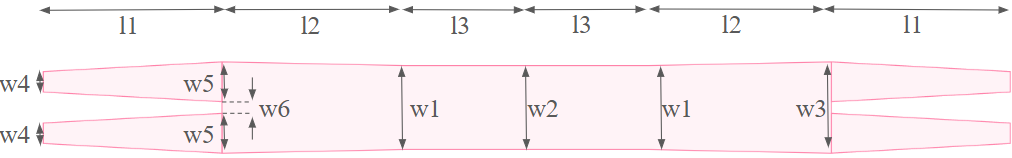

We start by creating a 3-dB multimode interference (MMI) coupler inspired by [3]. Initially, we scale all dimensions according to our operating wavelength (1.58 µm) since the original design was for 1.55 µm (we also slightly increased `l1` to get more even splitting). Then, to avoid port overlaps and reduce optical losses, we multiply all the widths by a factor of 1.35. Furthermore, according to the analytical expression for the beat length ($L_\pi$) of the MMI, given by:

$L_\pi = \frac{\pi}{\beta_0 - \beta_1} \approx \frac{4 n_r W_e^2}{3\lambda}$

the length is proportional to the square of the width. So, we scale all length dimensions by the square of this width-scaling factor (1.35²).

Below, we define the parametric component function for the 2x2 MMI coupler:




In [3]:
# Define a parametric 2x2 MMI splitter component
@pf.parametric_component
def mmi_2x2(
    *,
    l1=4.41,  # length of taper section at input
    l2=4.51,  # length of intermediate taper section
    l3=3.01,  # length of central multimode section
    w1=2.05,  # intermediate width near input/output
    w2=2.05,  # central section width
    w5=0.972,  # input taper narrow width
    w6=0.284,  # gap between input waveguides
    port_spec=tech.ports["TE_1550_500"]  # port specification for waveguides
):
    """
    Creates a parametric 2x2 multimode interference (MMI) splitter component.

    Parameters:
        l1, l2, l3 (float): Section lengths.
        w1, w2, w5, w6 (float): Section widths.
        port_spec: Specification for the optical ports.

    Returns:
        PhotonForge Component: Configured MMI with geometry and simulation model.
    """
    # Resolve port specification if provided as string
    if isinstance(port_spec, str):
        port_spec = pf.config.default_technology.ports[port_spec]

    # Initialize an empty component named "MMI2x2"
    mmi = pf.Component("MMI2x2")

    # Extract default waveguide width from port specification
    wg_width, _ = port_spec.path_profile_for("Si")

    # Calculate widths based on given parameters
    w3 = 2 * w5 + w6
    w4 = wg_width

    # Define paths for input and output waveguides
    input_wg_up = pf.Path((0, (w5 + w6) / 2), w4).segment((l1, 0), w5, relative=True)
    input_wg_down = input_wg_up.copy().mirror()
    output_wg_up = input_wg_up.copy().mirror(
        axis_endpoint=(l1 + l2 + l3, 1), axis_origin=(l1 + l2 + l3, 0)
    )
    output_wg_down = output_wg_up.copy().mirror()

    # Define the central multimode section of MMI
    central_section = (
        pf.Path((l1, 0), w3)
        .segment((l2, 0), w1, relative=True)
        .segment((l3, 0), w2, relative=True)
        .segment((l3, 0), w2, relative=True)
        .segment((l2, 0), w3, relative=True)
    )

    # Add the defined geometries to the silicon ("Si") layer
    mmi.add(
        "Si", input_wg_up, input_wg_down, output_wg_up, output_wg_down, central_section
    )

    # Automatically detect and add ports
    mmi.add_port(mmi.detect_ports([port_spec]))
    assert len(mmi.ports) == 4, "Port detection failed: expected exactly 4 ports."

    # Include the Tidy3D simulation model with specified port symmetries
    mmi.add_model(
        pf.Tidy3DModel(
            port_symmetries=[
                ("P1", "P0", "P3", "P2"),  # reflection symmetry about x axis
                ("P2", "P3", "P0", "P1"),  # reflection symmetry about y axis
                ("P3", "P2", "P1", "P0"),  # inversion symmetry about the origin
            ],
        ),
        "Tidy3DModel",
    )

    return mmi


# Instantiate the MMI component with default dimensions
mmi = mmi_2x2()


We now test and verify that the defined port symmetries of our MMI coupler are correct. This runs full simulations without assuming any symmetry, then compares the results against the model's declared `port_symmetries`. It verifies if the symmetry settings are valid within a given tolerance (default `atol=0.02`). 

In [4]:
# Define temporary wavelength range for symmetry testing
wavelength_temp = np.linspace(1.5, 1.6, 11)

# Test the defined port symmetries (assert if test fails)
assert mmi.active_model.test_port_symmetries(
    mmi, frequencies=pf.C_0 / wavelength_temp, grid_spec=8
)

Loading cached simulation from .tidy3d/pf_cache/4LF/fdtd_info-5CKRLRUFWIS6J7SVMKUQ263IP43DCH5RXTV5OUJHRYHVDHOIDYMA.json.


Loading cached simulation from .tidy3d/pf_cache/4LF/fdtd_info-SD7GT6RP66EVH2Y42CPO24ULVFQZ5MXC4CKP3F66HHY2XEBI36LQ.json.
Loading cached simulation from .tidy3d/pf_cache/4LF/fdtd_info-WIATPYI46AOMULCDMUOWKGS3SXP33WNGU7X43X5GBLDOPIY5W23Q.json.
Loading cached simulation from .tidy3d/pf_cache/4LF/fdtd_info-PGICIADQKUTTDLKUSQY33XBKZGVGYCRKMR77T7IZDUSDIV4PKMFQ.json.
Progress: 100% 


Progress: 100% 


We calculate the scattering matrix (S-matrix) for our MMI coupler at the defined wavelength range and visualize the results to evaluate its optical behavior. The total insertion loss is less than 0.08 dB and the power splits almost evenly between the output ports.


Loading cached simulation from .tidy3d/pf_cache/4LF/fdtd_info-C75UIYN2ABIOQQE4LEWKFFG3DNE6LTIVM4P322GTOKXEOCRCWQSA.json.
Progress: 100% 


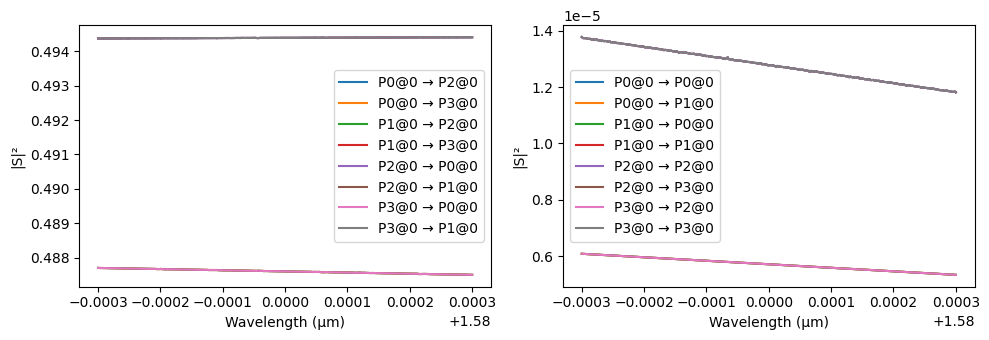

In [5]:
# Calculate the S-matrix of the MMI coupler over the specified wavelength range
s_matrix_mmi = mmi.s_matrix(pf.C_0 / wavelengths)

# Plot the calculated S-matrix
_ = pf.plot_s_matrix(s_matrix_mmi)

**Wrapping the MMI with S-Bends for Input/Output Access**

To improve routing and alignment within larger circuit designs, we encapsulate the 2×2 MMI with four S-bend waveguides. This setup ensures that the input and output ports are more spatially separated and accessible. 

We instantiate the S-bends, connect them to the four ports of the MMI, and assign new external ports. The resulting composite component, named `"MMI with S bends"`, is then visualized and assigned a circuit model for simulation (we avoid costly FDTD simulations because the S bends are very low loss).


In [6]:
# S-bend waveguide length and vertical displacement
sbend_length = 20
vertical_distance = 20

# Create a parametric S-bend waveguide with half vertical offset
s_bend = pf.parametric.s_bend(length=sbend_length, offset=vertical_distance / 2)

# Create a new component to hold the MMI with attached S-bends
mmi_with_sbend = pf.Component("MMI with S bends")

# Add a reference to the original MMI
mmi_ref = mmi_with_sbend.add_reference(mmi)

# Add four references to S-bend for the four ports of the MMI
s_bend0 = mmi_with_sbend.add_reference(s_bend)
s_bend1 = mmi_with_sbend.add_reference(s_bend).mirror()  # mirror for port 1
s_bend2 = mmi_with_sbend.add_reference(s_bend).mirror()  # mirror for port 2
s_bend3 = mmi_with_sbend.add_reference(s_bend)

# Connect S-bends to the respective MMI ports
s_bend0.connect("P1", mmi_ref["P0"])
s_bend1.connect("P1", mmi_ref["P1"])
s_bend2.connect("P1", mmi_ref["P2"])
s_bend3.connect("P1", mmi_ref["P3"])

# Add ports
mmi_with_sbend.add_reference_ports()

# Add a simulation-ready circuit model to the component
mmi_with_sbend.add_model(pf.CircuitModel())

# Visualize the final MMI component with S-bend waveguides
viewer(mmi_with_sbend)

### Phase Shifter

Next, we define essential parameters such as basic unit length (BUL), and propagation loss. We calculate the length of the straight section used as a thermal phase shifter based on these parameters. Additionally, we set up a model for the thermally tunable phase shifter, accounting for changes in refractive index as a function of applied voltage.


In [7]:
bul = 975  # Basic unit length (in microns)
alpha = 3  # Waveguide propagation loss (in dB/cm)


# Total length of access waveguides
access_length = 2 * sbend_length

# Compute MMI coupler length
mmi_length, _ = mmi_with_sbend.size()

# Calculate length of the straight waveguide used as phase shifter
phase_shifter_length = bul - 2 * mmi_length - access_length


# Create straight waveguide as the thermal phase shifter component
phase_shifter = pf.parametric.straight(
    length=phase_shifter_length, name="Phase Shifter"
)

# Solve for waveguide modes to obtain complex effective index across wavelengths
mode_solver = pf.port_modes(port_spec, pf.C_0 / wavelengths, group_index=True)
n_complex = mode_solver.data.n_complex.values.T

# Calculate imaginary part (k) of complex refractive index from loss
k = (alpha * wavelengths * 1e-4 * np.log(10)) / (40 * np.pi)


# Define voltage-dependent refractive index model
def index(voltage, resistance=9, coefficient=1e-3):
    """
    Calculate complex refractive index as a function of applied voltage.

    Parameters:
        voltage (float): Applied voltage (V).
        resistance (float): Heater resistance (Ω).
        coefficient (float): Proportionality constant.

    Returns:
        np.ndarray: Complex refractive index array.
    """
    dn = coefficient * voltage**2 / resistance
    return n_complex + dn + 1j * k


# Set the default thermal waveguide model at 0 V applied voltage
thermal_model = pf.WaveguideModel(n_complex=index(0))

# Add the defined thermal waveguide model to the phase shifter
_ = phase_shifter.add_model(thermal_model, "Waveguide")

Loading cached simulation from .tidy3d/pf_cache/TQJ/ms_info-4VFHUWOLBNOQSRJIVTYQ6JXSDL7CRNN7RUKM6Q2ZBU5BJ5E576QQ.json.


Progress: 100%


**Assembling the Tunable Basic Unit**

We now assemble the tunable unit, the core building block of our programmable circuit, by connecting previously defined components (MMI couplers and thermal phase shifters) according to the designed [netlist](../_autosummary/photonforge.component_from_netlist.rst#photonforge.component_from_netlist).


In [8]:
# Define netlist for assembling the tunable photonic unit
netlist_tu = {
    "name": "Tunable Unit",
    "instances": {
        "mmi1": mmi_with_sbend,  # input MMI coupler
        "ps0": phase_shifter,  # first thermal phase shifter
        "ps1": phase_shifter,  # second thermal phase shifter
        "mmi2": mmi_with_sbend,  # output MMI coupler
    },
    # Explicitly define connections between component ports
    "connections": [
        (("ps0", "P0"), ("mmi1", "P2")),
        (("ps1", "P0"), ("mmi1", "P3")),
        (("mmi2", "P0"), ("ps0", "P1")),
        (("mmi2", "P1"), ("ps1", "P1")),
    ],
    # Define external ports of the tunable unit
    "ports": [("mmi1", "P0"), ("mmi1", "P1"), ("mmi2", "P2"), ("mmi2", "P3")],
    # Assign circuit model to the assembled unit
    "models": [(pf.CircuitModel(), "Circuit")],
}

# Create a photonic component from the defined netlist
tunable_unit = pf.component_from_netlist(netlist_tu)

# Visualize the assembled tunable unit
viewer(tunable_unit)



**Different States of The Tunable Unit**


We analyze how the transmission and phase of the tunable unit change as a function of the applied voltage on one of the phase shifters. Specifically, we identify three important operational states:

1. **Cross state:** At 0 V, the optical signal from input port P₀ predominantly transfers to the diagonally opposite port P₃.
2. **Tunable coupler state:** At an intermediate voltage ($v_{tc}$), the input signal is evenly split between ports P₂ and P₃ ($|S_{20}|^2 = |S_{30}|^2$).
3. **Bar state:** At voltage $v_{bar}$, the signal from input port P₀ transmits straight through to port P₂, with minimal power transferred to port P₃ ($|S_{30}|^2 \approx 0$).

We identify these voltages by analyzing the calculated S-matrix transmission data. Linear interpolation is used to precisely find the voltage corresponding to the tunable coupler state, while the bar state is located by minimizing transmission to port P₃.

The following plots illustrate these states clearly by marking the identified voltages and showing both the transmission and phase responses as functions of the applied voltage.

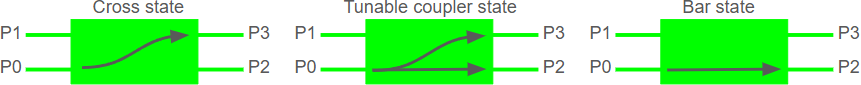



Loading cached simulation from .tidy3d/pf_cache/7QS/ms_info-UPJLHRLXON5Q3J725WNQW5ALKBOZHY4VFAUB3FEYIZ3KZJEZWDRQ.json.


Loading cached simulation from .tidy3d/pf_cache/SPH/ms_info-GDJMWUGBJCN5JE7NJLEFM2KY4WJF5RP55KJPY3UBK7EU7QGCJI2A.json.
Loading cached simulation from .tidy3d/pf_cache/R4N/ms_info-VKJMNZELQZULRJWYA35EBSI2WEDEZUWXE3PA4KSGFH34IVAFLO6A.json.
Loading cached simulation from .tidy3d/pf_cache/SFA/ms_info-VRYTUE76Z7LTM4GSTIKCKVQKENPQXWVZQCJNDGE47EAN2MO3GINA.json.


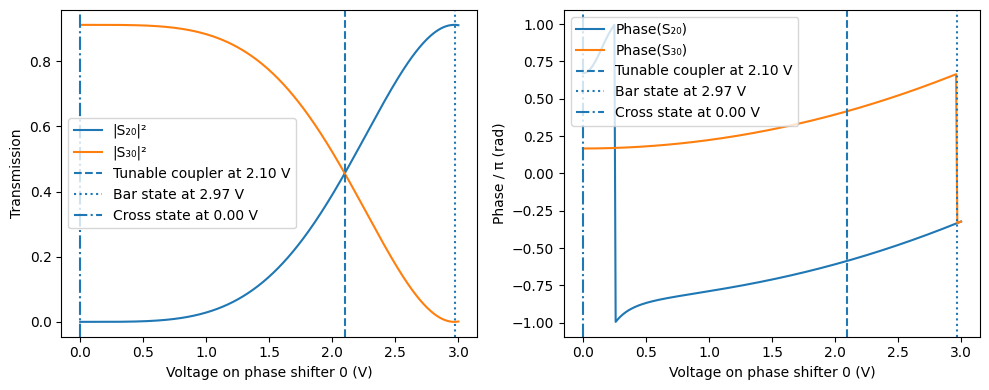

In [9]:
# Voltage range from 0 V to 3 V
voltages = np.linspace(0, 3, 301)

# Initialize arrays to store transmission and phase values
transmission = np.zeros((voltages.size, 2))
phase = np.zeros((voltages.size, 2))

# Central wavelength index for analysis
m = len(wavelengths) // 2

# Loop over voltage range to compute s-matrix responses
for i, v in enumerate(voltages):
    # Update refractive index based on voltage applied to phase shifter 0
    updates = {
        ("Phase Shifter", 0): {"model_updates": {"n_complex": index(v)}},
        ("Phase Shifter", 1): {"model_updates": {"n_complex": index(0)}},
    }

    # Calculate s-matrix at current voltage
    s = tunable_unit.s_matrix(
        pf.C_0 / wavelengths, model_kwargs={"updates": updates}, show_progress=False
    )

    # Record transmission magnitudes squared
    transmission[i, 0] = np.abs(s[("P0@0", "P2@0")][m]) ** 2
    transmission[i, 1] = np.abs(s[("P0@0", "P3@0")][m]) ** 2

    phase[i, 0] = np.angle(s[("P0@0", "P2@0")][m])
    phase[i, 1] = np.angle(s[("P0@0", "P3@0")][m])

# 1) Voltage at which |S20|^2 equals |S30|^2 via linear interpolation
D = transmission[:, 0] - transmission[:, 1]
sign_changes = np.where(np.sign(D[:-1]) * np.sign(D[1:]) < 0)[0]
i = sign_changes[0]
v1, v2 = voltages[i], voltages[i + 1]
d1, d2 = D[i], D[i + 1]

# Interpolated voltage for equal power split (tunable coupler state)
v_tc = v1 - d1 * (v2 - v1) / (d2 - d1)

# 2) Voltage where |S30|^2 is zero (bar state)
idx_zero = np.argmin(np.abs(transmission[:, 1]))
v_bar = voltages[idx_zero]

# Cross state voltage (by definition zero volts)
v_cross = 0

# Plot the transmission and phase responses
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

# Transmission plot
ax[0].plot(voltages, transmission[:, 0], label="|S₂₀|²")
ax[0].plot(voltages, transmission[:, 1], label="|S₃₀|²")
ax[0].axvline(v_tc, linestyle="--", label=f"Tunable coupler at {v_tc:.2f} V")
ax[0].axvline(v_bar, linestyle=":", label=f"Bar state at {v_bar:.2f} V")
ax[0].axvline(v_cross, linestyle="-.", label=f"Cross state at {v_cross:.2f} V")
ax[0].set_xlabel("Voltage on phase shifter 0 (V)")
ax[0].set_ylabel("Transmission")
ax[0].legend()

# Phase response plot
ax[1].plot(voltages, phase[:, 0] / np.pi, label="Phase(S₂₀)")
ax[1].plot(voltages, phase[:, 1] / np.pi, label="Phase(S₃₀)")
ax[1].axvline(v_tc, linestyle="--", label=f"Tunable coupler at {v_tc:.2f} V")
ax[1].axvline(v_bar, linestyle=":", label=f"Bar state at {v_bar:.2f} V")
ax[1].axvline(v_cross, linestyle="-.", label=f"Cross state at {v_cross:.2f} V")
ax[1].set_xlabel("Voltage on phase shifter 0 (V)")
ax[1].set_ylabel("Phase / π (rad)")
ax[1].legend()

# Display plots
plt.show()

## Unit Cell

Before constructing our main hexagonal programmable photonic circuit, we first define a unit cell composed of three interconnected tunable units. Each tunable unit (previously defined) functions as an independently configurable element, and this unit cell serves as the building block for assembling larger, more complex programmable structures.

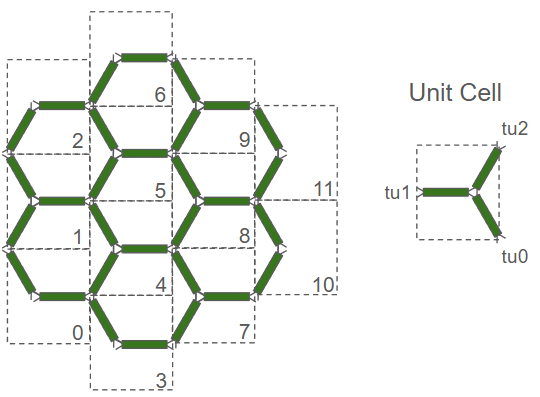


In [10]:
# Define netlist for creating a unit cell composed of three tunable units
netlist_uc = {
    "name": "Unit Cell",
    "instances": {
        "tu0": {  # bottom tunable unit
            "component": tunable_unit,
            "origin": (0, -1.5 * vertical_distance),
        },
        "tu1": {  # middle tunable unit
            "component": tunable_unit,
            "origin": (bul, 0),
        },
        "tu2": {  # top tunable unit
            "component": tunable_unit,
            "origin": (0, 1.5 * vertical_distance),
        },
    },
    # Automatically route connections between tunable units
    "routes": [
        (("tu1", "P0"), ("tu0", "P2"), pf.parametric.route),
        (("tu0", "P3"), ("tu2", "P2"), pf.parametric.route),
        (("tu1", "P1"), ("tu2", "P3"), pf.parametric.route),
    ],
    # External ports definition for further connectivity
    "ports": [
        ("tu0", "P0"),
        ("tu0", "P1"),
        ("tu2", "P0"),
        ("tu2", "P1"),
        ("tu1", "P2"),
        ("tu1", "P3"),
    ],
    # Circuit model assigned to the unit cell
    "models": [(pf.CircuitModel(), "Circuit")],
}

# Create the unit cell component from the defined netlist
unit_cell = pf.component_from_netlist(netlist_uc)

# Visualize the assembled unit cell
viewer(unit_cell)



Some unit cells located at the boundaries of the hexagonal circuit do not require all three tunable units. To accommodate these cases, we generate modified versions of the full unit cell by selectively removing one of the tunable units (`tu0`, `tu1`, or `tu2`). After removing the corresponding references and their associated ports, we automatically detect and reassign the external ports to ensure correct connectivity in the overall circuit layout.


In [11]:
# Create a copy of the unit cell without tunable unit tu0
cell_without_tu0 = unit_cell.copy()
cell_without_tu0.remove_port("P0")  # remove bottom-left port
cell_without_tu0.remove_port("P1")  # remove bottom-right port
cell_without_tu0.remove(cell_without_tu0.references[0])  # remove tu0 instance
cell_without_tu0.add_port(cell_without_tu0.detect_ports([port_spec]))  # update ports

# Create a copy of the unit cell without tunable unit tu1
cell_without_tu1 = unit_cell.copy()
cell_without_tu1.remove_port("P4")  # remove top-right port
cell_without_tu1.remove_port("P5")  # remove bottom-right port
cell_without_tu1.remove(cell_without_tu1.references[1])  # remove tu1 instance
cell_without_tu1.add_port(cell_without_tu1.detect_ports([port_spec]))  # update ports

# Create a copy of the unit cell without tunable unit tu2
cell_without_tu2 = unit_cell.copy()
cell_without_tu2.remove_port("P2")  # remove top-left port
cell_without_tu2.remove_port("P3")  # remove top-right port
cell_without_tu2.remove(cell_without_tu2.references[2])  # remove tu2 instance
cell_without_tu2.add_port(cell_without_tu2.detect_ports([port_spec]))  # update ports

['P6', 'P7']

## Full Programmable Circuit

We now define a function to construct the full programmable photonic circuit by arranging multiple unit cells in a hexagonal grid pattern. The `programmable_circuit` function allows us to specify the number of unit cells in each column and apply vertical offsets to achieve the desired hexagonal geometry.

Additionally, the function supports a `mapping` argument that enables selective replacement of unit cells at specific locations with alternate versions that omit one of the tunable units (typically used at circuit boundaries). 

The construction process involves the following steps:

1. Normalize the `mapping` input into a dictionary for efficient lookup.
2. Compute the horizontal (`px`) and vertical (`py`) pitch from the geometry of the unit cell.
3. Place either the default unit cell or a mapped variant at each grid position.
4. Route waveguides vertically within each column (connecting ports P3 to P0).
5. Add inter-column waveguide routing to connect neighboring columns (P4→P2 and P5→P1) while accounting for staggered rows.

Finally, we use this function to instantiate and visualize the complete programmable circuit layout.


In [12]:
# Function to construct a programmable hexagonal circuit from unit cells
def programmable_circuit(
    unit_cell=unit_cell,
    n_cells=[3, 4, 3, 2],  # number of unit cells per column
    offsets=[0, -0.5, 0, +0.5],  # vertical row offsets for hexagonal tiling
    mapping=None,  # optional mapping for variant unit cells
):
    """
    Build a programmable grid of copies of `unit_cell`, but at any
    (row, col) in `mapping` use the specified variant instead.

    mapping: list of tuples (variant_cell, row_idx, col_idx)
    """
    # 1) Convert mapping list to dictionary for fast lookup
    mapping = mapping or []
    mapping_dict = {(row, col): var for var, row, col in mapping}

    # 2) Compute horizontal and vertical pitch from base unit cell references
    px = 2 * (unit_cell.references[1].origin[0] - unit_cell.references[0].origin[0])
    py = 2 * (unit_cell.references[2].origin[1] - unit_cell.references[0].origin[1])

    # Create the main programmable circuit component
    circuit = pf.Component("Programmable Circuit")

    # 3) Place unit cells column by column with vertical offset
    for col_idx, (count, off) in enumerate(zip(n_cells, offsets)):
        x = col_idx * px
        for row in range(count):
            y = (row + off) * py
            cell_to_place = mapping_dict.get((row, col_idx), unit_cell)
            circuit.add_reference(pf.Reference(cell_to_place, origin=(x, y)))

    # 4) Add vertical (intra-column) routes connecting P3 to P0
    ref_start = 0
    for count in n_cells:
        for i in range(count - 1):
            a = circuit.references[ref_start + i]
            b = circuit.references[ref_start + i + 1]
            circuit.add(pf.parametric.route(port1=(b, "P0"), port2=(a, "P3")))
        ref_start += count

    # 5) Track starting index for each column
    col_starts = [0]
    for cnt in n_cells:
        col_starts.append(col_starts[-1] + cnt)

    # 6) Add horizontal (inter-column) routes for staggered hexagonal links
    for j in range(len(n_cells) - 1):
        s0, s1 = col_starts[j], col_starts[j + 1]
        n0, n1 = n_cells[j], n_cells[j + 1]

        # Decide shifting logic based on relative column heights
        steps = n0 - (0 if n0 < n1 else 1)
        d42, d51 = (0, 1) if n0 < n1 else (1, 0)

        for i in range(steps):
            # Route from P4 to P2
            src42 = circuit.references[s0 + i + d42]
            dst42 = circuit.references[s1 + i]
            circuit.add(pf.parametric.route(port1=(src42, "P4"), port2=(dst42, "P2")))

            # Route from P5 to P1
            src51 = circuit.references[s0 + i]
            dst51 = circuit.references[s1 + i + d51]
            circuit.add(pf.parametric.route(port1=(src51, "P5"), port2=(dst51, "P1")))

    return circuit


# Instantiate the full programmable circuit with custom grid layout
circuit = programmable_circuit(
    unit_cell, n_cells=[15, 16, 15, 16], offsets=[0, -0.5, 0, -0.5]
)

# Visualize the complete circuit
viewer(circuit)

### Hexagonal Programmable Circuit

Here, we construct the final hexagonal programmable photonic circuit using the `programmable_circuit` function. We define a `mapping` list to selectively replace certain unit cells at the circuit boundaries with variants that omit one of the tunable units. This ensures structural correctness and avoids unnecessary components at the edges of the layout.

The hexagonal grid is specified with four columns, where each column has a defined number of cells and vertical offset to achieve the hexagonal tiling. After constructing the circuit, we detect and assign external ports and add a simulation-ready circuit model.


In [13]:
# Define custom mapping to replace unit cells at boundary positions
mapping = [
    (cell_without_tu1, 1, 3),  # remove tu1 at (row 1, col 3)
    (cell_without_tu1, 0, 3),  # remove tu1 at (row 0, col 3)
    (cell_without_tu2, 3, 1),  # remove tu2 at (row 3, col 1)
    (cell_without_tu0, 0, 1),  # remove tu0 at (row 0, col 1)
    (cell_without_tu2, 2, 0),  # remove tu2 at (row 2, col 0)
    (cell_without_tu0, 0, 0),  # remove tu0 at (row 0, col 0)
]

# Construct the hexagonal programmable photonic circuit with mapping
circuit = programmable_circuit(
    unit_cell,
    n_cells=[3, 4, 3, 2],  # number of unit cells in each column
    offsets=[0, -0.5, 0, +0.5],  # row offset per column for hexagonal tiling
    mapping=mapping,  # use variant cells at specified locations
)

# Detect and assign external ports for simulation/connection
circuit.add_port(circuit.detect_ports([port_spec]))

# Add the circuit model for simulation and analysis
circuit.add_model(pf.CircuitModel(), "Circuit")

viewer(circuit)

### Unbalanced MZI

Using the programmable hexagonal circuit, we configure a specific routing to realize an **unbalanced MZI** with a path length difference of approximately 4 BULs. The selected path configuration corresponds to the layout shown in the figure, where each tunable unit is programmed into one of three operational states: **bar**, **cross**, or **tunable coupler**.

We set the phase shifters in each relevant tunable unit to the appropriate voltages (`v_bar`, `v_cross`, or `v_tc`) to enforce the desired signal routing. The light entering from the input port is split and routed through two distinct paths of different lengths, resulting in a phase difference at the output due to the path imbalance.

Once the configuration is defined, we use `model_updates` to modify the refractive index of each phase shifter according to the applied voltage. This mechanism recomputes the circuit’s S-matrix using a **semi-analytical circuit model**, which significantly speeds up simulation. Instead of running a full electromagnetic simulation from scratch, the system reuses precomputed mode and coupling data to efficiently evaluate how the circuit responds to the updated device states.

We then compute the S-matrix of the full circuit using these updates and plot the transmission from the input port `P4` to output ports `P16` and `P20` in dB scale, focusing on a narrow wavelength band around the central wavelength (1.58 µm) to visualize the interference behavior.

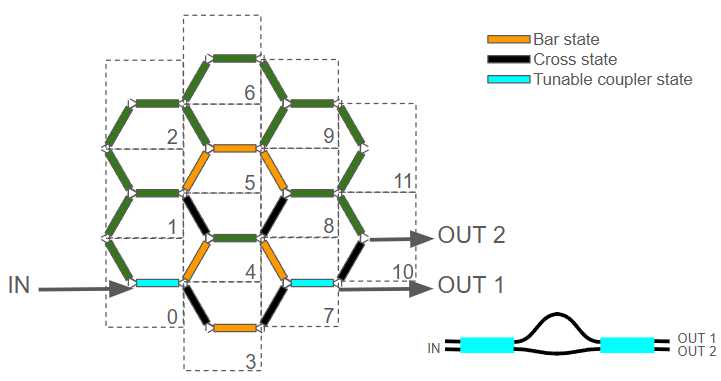


Loading cached simulation from .tidy3d/pf_cache/R7I/ms_info-NUMXNIKH5Z23X6GAQHSCJ77SLMK26JTAQGS5PKCZF2KP2D3SPT4Q.json.
Loading cached simulation from .tidy3d/pf_cache/IEF/ms_info-GXGUDKMCJZFLL2UIZUNYJLIGL2X3BXS6IRMTM7HIVFNURF545RWQ.json.


Progress: 100% 


(1.57975, 1.58025)

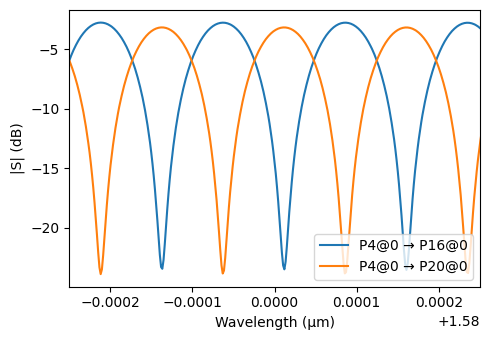

In [14]:
# Define a table of update instructions as (unit_cell, tunable_unit, voltage)
update_table = [
    (0, 0, v_tc),
    (3, 1, v_cross),
    (4, 0, v_bar),
    (4, 2, v_cross),
    (5, 0, v_bar),
    (3, 0, v_bar),
    (5, 1, v_bar),
    (7, 0, v_cross),
    (7, 2, v_bar),
    (8, 0, v_cross),
    (8, 2, v_bar),
    (7, 1, v_tc),
    (10, 0, v_cross),
]

# Create the updates dictionary using the table
updates = {
    ("Unit Cell", uc, "Tunable Unit", tu, "Phase Shifter", 0): {
        "model_updates": {"n_complex": index(v)}
    }
    for uc, tu, v in update_table
}

# Compute the S-matrix of the full circuit using the programmed updates
s_matrix = circuit.s_matrix(pf.C_0 / wavelengths, model_kwargs={"updates": updates})

# Plot transmission from input port P4 to output ports P16 and P20 in dB
fig, ax = pf.plot_s_matrix(
    s_matrix, input_ports=["P4"], output_ports=["P16", "P20"], y="dB"
)
ax[0].set_xlim(1.57975, 1.58025)

**Sweeping the Tunable Coupler Voltage**

To study the tunability of the unbalanced Mach-Zehnder Interferometer (MZI), we sweep the voltage applied to the two tunable couplers used in the configuration. These couplers were initially set to `v_tc`, and here we evaluate the system’s spectral response as we slightly detune this voltage to `0.9 × v_tc` and `0.8 × v_tc`.

We update the complex refractive index of the corresponding phase shifters for each voltage and recompute the circuit's S-matrix. The resulting transmission spectra to the two output ports (`P16` and `P20`) are plotted in dB scale to observe changes in the interference pattern, indicating the effect of voltage tuning on output power distribution.


Progress: 100% 


Progress: 100% 


Progress: 100% 


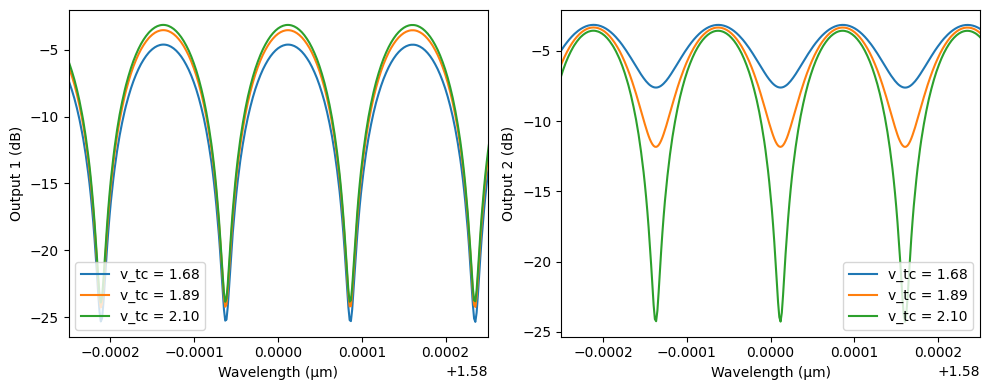

In [15]:
# --- prepare your sweep parameters ---
v_tc_values = [0.8 * v_tc, 0.9 * v_tc, v_tc]  # voltage sweep for tunable couplers
colors = ["C0", "C1", "C2"]  # matplotlib color codes
labels = [f"v_tc = {v:.2f}" for v in v_tc_values]  # labels for legend

# Specify the two tunable couplers whose voltage will be swept
tc_keys = [
    ("Unit Cell", 0, "Tunable Unit", 0, "Phase Shifter", 0),
    ("Unit Cell", 7, "Tunable Unit", 1, "Phase Shifter", 0),
]

# Create plot with two subplots: one for each output port
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

# Loop through the voltage values to compute and plot results
for v_tc, color, label in zip(v_tc_values, colors, labels):
    # Copy the base updates and override the tunable coupler voltages
    upd = {**updates}
    for m in tc_keys:
        upd[m] = {"model_updates": {"n_complex": index(v_tc)}}

    # Compute the S-matrix for the current voltage setting
    sm = circuit.s_matrix(frequencies, model_kwargs={"updates": upd})

    # Extract S-parameters from input to each output port
    out1 = sm[("P0@0", "P16@0")]  # output 1
    out2 = sm[("P0@0", "P20@0")]  # output 2

    # Convert to dB scale
    out1_db = 20 * np.log10(np.abs(out1))
    out2_db = 20 * np.log10(np.abs(out2))

    # Plot transmission to both output ports
    ax[0].plot(wavelengths, out1_db, color=color, label=label)
    ax[1].plot(wavelengths, out2_db, color=color, label=label)

# Set axis labels and formatting for Output 1
ax[0].set_xlim(1.57975, 1.58025)
ax[0].set_xlabel("Wavelength (µm)")
ax[0].set_ylabel("Output 1 (dB)")
ax[0].legend()

# Set axis labels and formatting for Output 2
ax[1].set_xlim(1.57975, 1.58025)
ax[1].set_xlabel("Wavelength (µm)")
ax[1].set_ylabel("Output 2 (dB)")
ax[1].legend()

# Show the final plot
plt.show()

### Ring Resonator

We configure the programmable hexagonal photonic circuit to realize a **ring resonator** by programming a closed loop of tunable units as shown in the schematic. The loop is formed by setting specific units into **bar** or **tunable coupler** states to guide light around the ring.

The input light enters at port `P12` and circulates through the ring, with output observed at ports `P4` and `P8`. The transmission spectrum is plotted in dB scale to reveal resonant behavior within a narrow wavelength band centered at 1.58 µm.

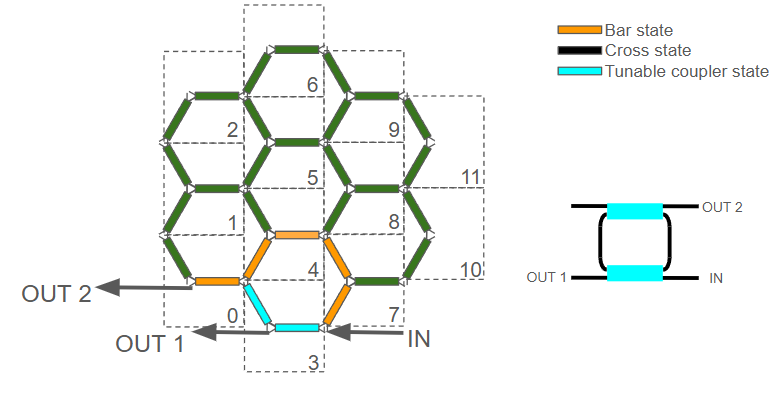




Progress: 100% 


(1.57975, 1.58025)

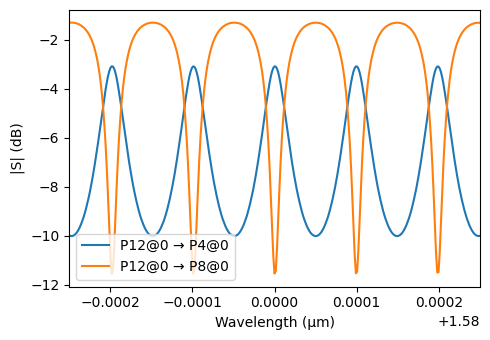

In [16]:
# Define a table of update instructions for the ring resonator configuration
ring_update_table = [
    (0, 0, v_bar),
    (3, 0, v_tc),
    (3, 1, v_tc),
    (4, 0, v_bar),
    (4, 1, v_bar),
    (7, 0, v_bar),
    (7, 2, v_bar),
]

# Create the updates dictionary using the table
updates = {
    ("Unit Cell", uc, "Tunable Unit", tu, "Phase Shifter", 0): {
        "model_updates": {"n_complex": index(v)}
    }
    for uc, tu, v in ring_update_table
}

# Compute the circuit S-matrix with the ring resonator configuration
s_matrix = circuit.s_matrix(pf.C_0 / wavelengths, model_kwargs={"updates": updates})

# Plot the transmission spectrum from input port P12 to output ports P4 and P8
fig, ax = pf.plot_s_matrix(
    s_matrix, input_ports=["P12"], output_ports=["P4", "P8"], y="dB"
)
ax[0].set_xlim(1.57975, 1.58025)


**Tuning the Coupling Strength in the Ring Resonator**

To examine how the resonance behavior of the ring resonator changes with different coupling strengths, we perform a voltage sweep on the two tunable couplers that control coupling into and out of the ring. By varying the voltage around the nominal tunable coupler setting `v_tc`, we effectively change the power coupling ratio between the bus waveguide and the resonator.

Progress: 100% 


Progress: 100% 


Progress: 100% 


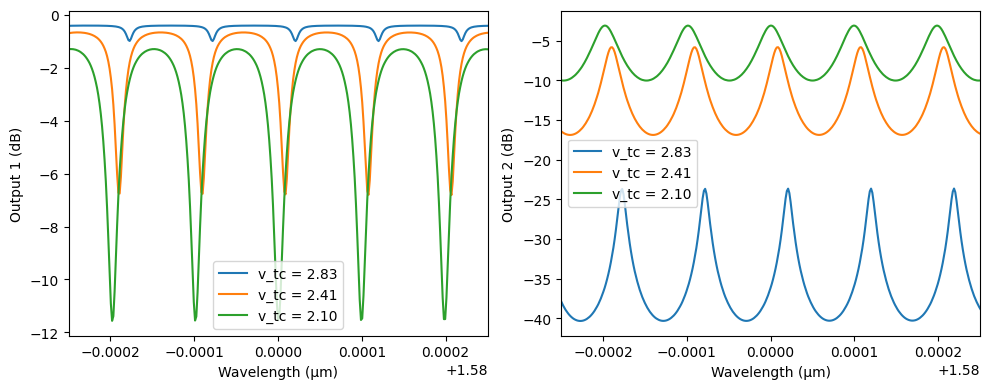

In [17]:
# --- prepare your sweep parameters ---
v_tc_values = [1.35 * v_tc, 1.15 * v_tc, v_tc]
colors = ["C0", "C1", "C2"]
labels = [f"v_tc = {v:.2f}" for v in v_tc_values]

# pick out the two Phase Shifter keys that you want to vary with v_tc
tc_keys = [
    ("Unit Cell", 3, "Tunable Unit", 0, "Phase Shifter", 0),
    ("Unit Cell", 3, "Tunable Unit", 1, "Phase Shifter", 0),
]

# name of the S-parameter you care about:
port_pair = ()

fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

for v_tc, color, label in zip(v_tc_values, colors, labels):
    # make a copy of your updates and override v_tc on the two keys
    upd = {**updates}
    for m in tc_keys:
        upd[m] = {"model_updates": {"n_complex": index(v_tc)}}

    # compute new S-matrix
    sm = circuit.s_matrix(frequencies, model_kwargs={"updates": upd})

    # extract the vector and convert to dB
    out1 = sm[("P12@0", "P8@0")]  # complex values
    out2 = sm[("P12@0", "P4@0")]  # complex values
    out1_db = 20 * np.log10(np.abs(out1))  # to dB
    out2_db = 20 * np.log10(np.abs(out2))  # to dB

    # plot
    ax[0].plot(wavelengths, out1_db, color=color, label=label)
    ax[1].plot(wavelengths, out2_db, color=color, label=label)

# formatting
ax[0].set_xlim(1.57975, 1.58025)
ax[0].set_xlabel("Wavelength (µm)")
ax[0].set_ylabel("Output 1 (dB)")
ax[0].legend()
ax[1].set_xlim(1.57975, 1.58025)
ax[1].set_xlabel("Wavelength (µm)")
ax[1].set_ylabel("Output 2 (dB)")
ax[1].legend()
plt.show()